### Model inspired by:

- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen

### Implementation aspects:

- This implementation is more like pseudo steady-state finite difference method rather than fully dynamic FEM (i.e. the model can be applied to normal dynamic pipelay condition as a rough estimate)

In [1]:
import numpy as np
import inspect
import matplotlib.pyplot as plt
import scipy
from datetime import datetime
from scipy.optimize import root
from scipy.integrate import solve_ivp
from scipy import interpolate
import plotly.graph_objects as go

In [2]:
import sys

In [3]:
sys.path.insert(0, "../../../miscellaneous/Ocean_Intella_1/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../miscellaneous/Ocean_Intella_1/PythonVehicleSimulator-master/src")

In [4]:
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

### Modelling data:

In [5]:
mp = 59.1       #  (submerged pipe weight) [kg/m]
N = 20       # number of modelling nodes

In [6]:
mi = [mp for i in range(N)]

In [7]:
# Vessel:

# L - the hull length
# Xg - x-center of gravity

L = 168 # [m]
B = 46
H = 13.5
Xg = L/2 # [m]
mn = 39_989_000  # mass of the vessel, [kg]

In [8]:
Fx_0 = 604.76664*1000
Fy_0 = 0.7*Fx_0
LTD = 255.21207

In [9]:
lx, ly, lz = L/2, B/2, H/2

In [10]:
vessel_mass = mn/L # mass over length of the vessel

In [11]:
diag_Jrho0 = 1e2*np.array([1, 1, 2]) # [m^4] 
Jrho0 = np.diag(diag_Jrho0)

In [12]:
qw = 1025 # Water density [kg/m3]
d0 = 0.508 # Outer diameter of pipe, [m]
dI= (508-22.1*2)/1000 # Inner diameter of pipe, [m]

In [13]:
rho_steel=7850 #kg/m^3
rho_steel *= 9.81

In [14]:
Ar=np.pi*((d0/2)**2-(dI/2)**2) 
Iy_ = 1/4*np.pi*rho_steel*((d0/2)**4-(dI/2)**4)
Iz_ = 1/2*np.pi*rho_steel*((d0/2)**4-(dI/2)**4)
J_ = 1/32*np.pi*(d0**4-dI**4)

In [15]:
E = 207e9
G = 79.3e9

In [16]:
h = 40 # water depth

In [17]:
# Fossen book p.181
def vessel_inertia_moment(mn, Xg, L):
    r = 0.25*L
    Ir = mn*r**2
    Iz=mn*Xg**2 + Ir
    return Iz

In [18]:
vessel_inertia = vessel_inertia_moment(mn, Xg, L)

In [19]:
# Underwater current: 
dv1_curr = np.zeros(N)
dv2_curr = np.zeros(N)
dv3_curr = np.zeros(N)

In [20]:
# Constants: 

In [21]:
diag_DT = 1.5*np.array([1, 1, 1])
DT=np.diag(diag_DT)

In [22]:
diag_CT = 1e9*np.array([1, 1, 1 ])  
CT=np.diag(diag_CT)

In [23]:
diag_CR = 1e11*np.array([1, 1, 1])
CR=np.diag(diag_CR)

In [24]:
diag_DR = 1.5*np.array([1, 1, 1])
DR=np.diag(diag_DR)

In [25]:
# for testing:

In [26]:
φ = np.random.rand(N)
θ = np.random.rand(N)
ψ = np.random.rand(N)

In [27]:
φ

array([0.79585423, 0.6139052 , 0.17823636, 0.4316553 , 0.16485537,
       0.65651467, 0.87302198, 0.34344605, 0.21079741, 0.07687644,
       0.242181  , 0.92308551, 0.42654214, 0.00392618, 0.99680797,
       0.1455227 , 0.62753559, 0.27091534, 0.57423401, 0.83364996])

In [28]:
dφ = np.random.rand(N)
dθ = np.random.rand(N)
dψ = np.random.rand(N)

In [29]:
ddφ = np.random.rand(N)
ddθ = np.random.rand(N)
ddψ = np.random.rand(N)

In [30]:
x = np.random.rand(N)
y = np.random.rand(N)
z = np.random.rand(N)

In [31]:
dx = np.random.rand(N)
dy = np.random.rand(N)
dz = np.random.rand(N)

In [32]:
# integration parameters
tspan = (0., 50)

coefs = [1, 1, 1, 1, 1, 1]
k500 = 6
lift_reduction_factor=1
vessel_motion_calibration_coefficient = 1e3 # to control dynamics

### Main functions:

In [34]:
def Π0(φθψ):
    φ0,θ0,ψ0=φθψ
    return np.array([[np.cos(θ0),0,np.cos(φ0)*np.sin(θ0)],
                  [0,1,-np.sin(φ0)],
                  [-np.sin(θ0),0,np.cos(φ0)*np.cos(θ0)]])

In [35]:
def Π(φ,θ,ψ):
    φθψ=np.stack((φ,θ,ψ), axis=1)
    return np.apply_along_axis(Π0, 1, φθψ)

In [36]:
Π(φ,θ,ψ)

array([[[ 0.65415142,  0.        ,  0.52920849],
        [ 0.        ,  1.        , -0.71446155],
        [-0.75636362,  0.        ,  0.4576932 ]],

       [[ 0.6377545 ,  0.        ,  0.62959749],
        [ 0.        ,  1.        , -0.57606397],
        [-0.7702397 ,  0.        ,  0.52130347]],

       [[ 0.9519323 ,  0.        ,  0.30145593],
        [ 0.        ,  1.        , -0.17729415],
        [-0.30630849,  0.        ,  0.9368517 ]],

       [[ 0.99901171,  0.        ,  0.04037082],
        [ 0.        ,  1.        , -0.41837484],
        [-0.04444782,  0.        ,  0.90737682]],

       [[ 0.74560649,  0.        ,  0.6573517 ],
        [ 0.        ,  1.        , -0.16410967],
        [-0.6663865 ,  0.        ,  0.73549763]],

       [[ 0.9670107 ,  0.        ,  0.2017824 ],
        [ 0.        ,  1.        , -0.61035975],
        [-0.25473577,  0.        ,  0.76599272]],

       [[ 0.99580104,  0.        ,  0.05881827],
        [ 0.        ,  1.        , -0.7662741 ],
        

In [37]:
def w_e(φ,θ,ψ,dφ,dθ,dψ): 
    return np.einsum('ijk,ik->ij', Π(φ,θ,ψ), np.stack((dφ,dθ,dψ), axis=1))

In [38]:
w_e(φ,θ,ψ,dφ,dθ,dψ)

array([[ 0.156603  ,  0.93615337, -0.16801161],
       [ 0.82176066, -0.21645986, -0.33623827],
       [ 0.3200334 ,  0.33407538,  0.51663345],
       [ 0.70761093,  0.48182814,  0.75725475],
       [ 0.83158747,  0.70862289,  0.22788319],
       [ 1.01423277,  0.26074959,  0.20270208],
       [ 1.01071785,  0.25634015,  0.27660356],
       [ 0.68834642,  0.31134537, -0.49098655],
       [ 0.07083057,  0.40076098,  0.02699781],
       [ 1.01588136,  0.09165624,  0.23677095],
       [ 0.5574972 ,  0.69066371, -0.42667321],
       [ 0.1455095 ,  0.01446459,  0.01642211],
       [ 0.39728698,  0.12042602,  0.24606541],
       [ 0.47409478,  0.50884226, -0.08661506],
       [ 0.47766043, -0.38879962,  0.35408937],
       [ 0.37716867,  0.63174847,  0.16441666],
       [ 0.92800532,  0.13007733, -0.21470552],
       [ 1.06205063,  0.14837978,  0.21962747],
       [ 1.12903529,  0.37570236,  0.21211996],
       [ 0.8485025 , -0.30022962,  0.36344467]])

In [39]:
def dw_e(φ,θ,ψ,dφ,dθ,dψ,ddφ,ddθ,ddψ):
    return (np.einsum('ijk,ik->ij', Π(φ,θ,ψ), np.stack((ddφ,ddθ,ddψ), axis=1))+
        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ), np.stack((dφ,dθ,dψ), axis=1)))

In [40]:
dw_e(φ,θ,ψ,dφ,dθ,dψ,ddφ,ddθ,ddψ)

array([[ 1.16547494,  1.38825019, -0.57012948],
       [ 1.61003289, -0.11687764, -0.08909016],
       [ 0.66925168,  0.62831701,  0.90275162],
       [ 1.96073885,  0.09072013,  0.37618851],
       [ 1.95329889,  1.22472881,  0.22331884],
       [ 1.71298457,  0.74542704, -0.39953457],
       [ 1.02766141, -0.04383443, -0.10168459],
       [ 1.44938474,  0.3973977 , -0.55681277],
       [ 0.80518908,  1.35977047, -0.58739328],
       [ 1.1654223 ,  0.5093641 ,  0.49886113],
       [ 1.38882178,  1.02884491, -0.5512874 ],
       [ 0.86863496,  0.22156055, -0.17010696],
       [ 0.96659801,  0.91678677,  0.17937281],
       [ 1.44214585,  1.37128437, -0.36142059],
       [ 1.58304949, -0.00453664,  0.64342545],
       [ 1.21247206,  1.08395766,  0.43479692],
       [ 1.05447869,  0.50710319, -0.06361663],
       [ 2.04895687,  0.30448387,  0.66188955],
       [ 1.51734934,  0.20178807,  0.17962025],
       [ 1.17907808, -0.10725947,  0.30976088]])

In [41]:
def phi(x,y,z): return np.stack((x,y,z), axis=1) 
def theta(φ,θ,ψ): return np.stack((φ,θ,ψ), axis=1) 

In [42]:
phi(x,y,z)

array([[0.46842527, 0.50330483, 0.8477872 ],
       [0.96312048, 0.89522943, 0.3435151 ],
       [0.1488136 , 0.18044621, 0.54189492],
       [0.73508843, 0.77539222, 0.75704519],
       [0.35223755, 0.91332313, 0.96709516],
       [0.92411491, 0.1187809 , 0.76238191],
       [0.47778035, 0.32836022, 0.20827307],
       [0.35879157, 0.0164337 , 0.70136556],
       [0.45227628, 0.66309347, 0.35415176],
       [0.79828032, 0.38700888, 0.04492893],
       [0.98671915, 0.63147454, 0.54649049],
       [0.87191964, 0.22585093, 0.10304551],
       [0.09410691, 0.31477096, 0.0237786 ],
       [0.55370559, 0.91644907, 0.30639705],
       [0.54423323, 0.99505483, 0.99700024],
       [0.84291325, 0.10212975, 0.35326718],
       [0.2490367 , 0.19406714, 0.66243405],
       [0.41532147, 0.76226894, 0.44876101],
       [0.351072  , 0.58597537, 0.12103632],
       [0.4156403 , 0.49207726, 0.80936456]])

In [43]:
theta(φ,θ,ψ)

array([[0.79585423, 0.85773618, 0.98511592],
       [0.6139052 , 0.87921692, 0.6880714 ],
       [0.17823636, 0.31131269, 0.78786219],
       [0.4316553 , 0.04446247, 0.43886112],
       [0.16485537, 0.72935184, 0.35830086],
       [0.65651467, 0.25757445, 0.93658647],
       [0.87302198, 0.09167232, 0.30459715],
       [0.34344605, 0.64303324, 0.65618125],
       [0.21079741, 0.85689666, 0.17444587],
       [0.07687644, 0.72964515, 0.63146193],
       [0.242181  , 0.77094912, 0.20814602],
       [0.92308551, 0.62541982, 0.45263141],
       [0.42654214, 0.91727927, 0.73157425],
       [0.00392618, 0.97719128, 0.75633758],
       [0.99680797, 0.40654516, 0.50861513],
       [0.1455227 , 0.2324654 , 0.45614529],
       [0.62753559, 0.78888862, 0.9022949 ],
       [0.27091534, 0.31401222, 0.96154287],
       [0.57423401, 0.50513479, 0.36526104],
       [0.83364996, 0.02590792, 0.16614763]])

In [44]:
def ω(φ,θ,ψ): 
    return np.einsum('ijk,ik->ij', Π(φ,θ,ψ), theta(φ,θ,ψ))

In [45]:
ω(x,y,z)

array([[ 0.77519748,  0.12054438,  0.43672495],
       [ 0.755331  ,  0.61321136, -0.62892333],
       [ 0.24257565,  0.10010219,  0.50049724],
       [ 0.9180469 ,  0.26767778, -0.11352693],
       [ 0.93375352,  0.57967642,  0.27591407],
       [ 0.9720392 , -0.48966678,  0.34662048],
       [ 0.51189853,  0.23259434,  0.02098874],
       [ 0.36953471, -0.22984591,  0.65071921],
       [ 0.55251711,  0.50832417, -0.02736068],
       [ 0.75107621,  0.35483271, -0.2722486 ],
       [ 0.97433646,  0.17558053, -0.33925748],
       [ 0.86462215,  0.14696285, -0.13064246],
       [ 0.09681244,  0.31253653, -0.00662513],
       [ 0.54379255,  0.7553324 , -0.28071359],
       [ 1.01176332,  0.47884574,  0.00790222],
       [ 0.86248244, -0.16161403,  0.14786377],
       [ 0.36817194,  0.03079669,  0.58191953],
       [ 0.58394281,  0.58120101,  0.01017639],
       [ 0.35535561,  0.54435042, -0.09945396],
       [ 0.71615898,  0.16527544,  0.45622881]])

In [46]:
def Ret(φ,θ,ψ):
    
    def Ret0(arr):
        φ,θ,ψ=arr
        Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

        Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

        Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])


        return np.array(np.dot(np.dot(Cθ,Cφ),Cψ) )
    
    arr=np.stack((φ,θ,ψ), axis=1)
    return np.apply_along_axis(Ret0, 1, arr)

In [47]:
Ret(φ,θ,ψ)

array([[[ 0.8119218 , -0.24641703,  0.52920849],
        [ 0.58306424,  0.38675675, -0.71446155],
        [-0.02861947,  0.88864946,  0.4576932 ]],

       [[ 0.77442334, -0.06225349,  0.62959749],
        [ 0.51909163,  0.63142234, -0.57606397],
        [-0.36167992,  0.77293617,  0.52130347]],

       [[ 0.70995231, -0.63646842,  0.30145593],
        [ 0.69761734,  0.69418789, -0.17729415],
        [-0.09642492,  0.33617128,  0.9368517 ]],

       [[ 0.91224307, -0.40765521,  0.04037082],
        [ 0.3859338 ,  0.82220289, -0.41837484],
        [ 0.13735968,  0.39724001,  0.90737682]],

       [[ 0.73660694, -0.15905647,  0.6573517 ],
        [ 0.34592897,  0.92379714, -0.16410967],
        [-0.58115692,  0.34828132,  0.73549763]],

       [[ 0.69823944, -0.68683735,  0.2017824 ],
        [ 0.63808796,  0.46936632, -0.61035975],
        [ 0.32450801,  0.55493217,  0.76599272]],

       [[ 0.97100011, -0.23173086,  0.05881827],
        [ 0.19269561,  0.61293752, -0.7662741 ],
        

In [48]:
def d_s(func, a, b, c, φ, θ, ψ): 
    
    sig = inspect.signature(func)
    num_args = len(sig.parameters)
    
    if num_args==3:
        fu = func(a, b, c)
    else:
        fu = func(a, b, c, φ, θ, ψ)

    def S(arr):
        a1, a2, a3 = arr[0],arr[1],arr[2]
        return np.array([[0, -a3, a2 ],
                         [a3, 0, -a1],
                        [-a2, a1, 0]])
    
    S0 = np.apply_along_axis(S, 1, ω(φ,θ,ψ))

    
    return np.einsum('ijk,ik->ij',S0, fu).T

In [49]:
d_s(phi,x,y,z,φ, θ, ψ).T

array([[ 0.20651829, -0.95411118,  0.45231913],
       [ 0.26806366, -0.39325678,  0.27328479],
       [-0.03033258, -0.1189296 ,  0.04793235],
       [-0.39923381, -0.06125449,  0.45039374],
       [ 0.5081346 , -0.29252321,  0.09118454],
       [-0.30480004, -0.11965315,  0.38810308],
       [-0.06726941, -0.12986628,  0.3590619 ],
       [ 0.29128722, -0.34909843, -0.14083158],
       [ 0.32212596, -0.11608414, -0.19402783],
       [-0.13119051,  0.31229986, -0.35914526],
       [ 0.40907841, -0.19538078, -0.51284976],
       [ 0.09929831, -0.37173422, -0.02546091],
       [-0.00624823, -0.01250311,  0.19023906],
       [-0.08622837,  0.03967944,  0.03714445],
       [ 0.11932199, -1.09816828,  1.03089108],
       [ 0.01732554,  0.25517873, -0.11511194],
       [ 0.15817636, -0.61895406,  0.12186409],
       [-0.58246117,  0.08716304,  0.39100312],
       [ 0.04269852, -0.08212477,  0.27374297],
       [-0.12290457, -0.63941448,  0.45186734]])

In [50]:
d_s(theta, φ, θ, ψ, φ, θ, ψ).T

array([[ 0.28119986, -1.14666569,  0.77122147],
       [ 0.43260253, -0.63755583,  0.42869523],
       [-0.07756655, -0.19897036,  0.09616806],
       [-0.0779182 , -0.0334162 ,  0.08002434],
       [ 0.12817809, -0.10309817,  0.15088994],
       [-0.43587577, -0.41039889,  0.41839928],
       [-0.05371056, -0.16989252,  0.20507395],
       [ 0.09142802, -0.32436681,  0.27001389],
       [ 0.18392636, -0.05660933,  0.05581757],
       [ 0.12508223, -0.26906636,  0.29567434],
       [ 0.16844367, -0.07123294,  0.06785196],
       [ 0.31921328, -0.70556585,  0.32391415],
       [ 0.38883527, -0.54829903,  0.4607717 ],
       [ 0.32661379, -0.47419543,  0.61096699],
       [ 0.04666861, -0.66128008,  0.43710964],
       [-0.01843558, -0.05298902,  0.03288625],
       [ 0.17905973, -0.82306869,  0.59508611],
       [-0.19591128, -0.30686762,  0.15541226],
       [ 0.11684019, -0.24321951,  0.15267171],
       [-0.01846689, -0.06387502,  0.10261832]])

In [51]:
def ne(x, y, z, φ, θ, ψ):
    RET = Ret(φ,θ,ψ)
    A = np.einsum('ijk,ikp->ijp',np.einsum('ijk,kp->ijp',RET, CT), np.transpose(RET,(0,2,1))) 
    B = d_s(phi, x, y, z, φ, θ, ψ).T
#     t1=np.einsum('ijk,kp->ijp',RET, np.array([0,0,1]).reshape(3,1)).squeeze()
    return np.einsum('ijk,ik->ij', A, B 
#                      - t1
                    )

In [52]:
ne(x, y, z, φ, θ, ψ)

array([[ 2.06518295e+08, -9.54111181e+08,  4.52319134e+08],
       [ 2.68063655e+08, -3.93256782e+08,  2.73284787e+08],
       [-3.03325811e+07, -1.18929600e+08,  4.79323498e+07],
       [-3.99233811e+08, -6.12544914e+07,  4.50393738e+08],
       [ 5.08134598e+08, -2.92523213e+08,  9.11845417e+07],
       [-3.04800041e+08, -1.19653146e+08,  3.88103084e+08],
       [-6.72694103e+07, -1.29866283e+08,  3.59061899e+08],
       [ 2.91287223e+08, -3.49098434e+08, -1.40831581e+08],
       [ 3.22125959e+08, -1.16084137e+08, -1.94027831e+08],
       [-1.31190515e+08,  3.12299861e+08, -3.59145261e+08],
       [ 4.09078411e+08, -1.95380777e+08, -5.12849758e+08],
       [ 9.92983131e+07, -3.71734217e+08, -2.54609149e+07],
       [-6.24823072e+06, -1.25031105e+07,  1.90239063e+08],
       [-8.62283748e+07,  3.96794379e+07,  3.71444479e+07],
       [ 1.19321986e+08, -1.09816828e+09,  1.03089108e+09],
       [ 1.73255426e+07,  2.55178734e+08, -1.15111937e+08],
       [ 1.58176361e+08, -6.18954057e+08

In [53]:
d_s(ne, x, y, z, φ, θ, ψ).T

array([[-7.45258430e+07, -5.02489411e+08, -1.02591242e+09],
       [ 8.70596045e+07, -2.55988029e+08, -4.53763072e+08],
       [ 8.95167292e+07, -4.02496048e+07, -4.32191608e+07],
       [-3.94534155e+07, -3.53522514e+08, -8.30517301e+07],
       [ 1.06096541e+08,  4.54012604e+07, -4.45584308e+08],
       [-5.60646618e+07, -4.87431237e+08, -1.94307120e+08],
       [-3.59605385e+07, -3.26319304e+08, -1.24760993e+08],
       [ 4.12812835e+07,  1.74926883e+08, -3.48231484e+08],
       [-1.64708372e+08,  3.64551409e+07, -2.95260249e+08],
       [-3.75191991e+08,  1.16465444e+08,  2.38326331e+08],
       [-3.74434725e+08,  1.51552788e+08, -3.56407819e+08],
       [-1.25317187e+08, -8.55156000e+06, -3.63886289e+08],
       [ 1.17751248e+08, -1.50345753e+08, -6.01376280e+06],
       [ 1.95294268e+07, -5.95679628e+07,  1.08969557e+08],
       [-1.75505168e+08, -1.07319195e+09, -1.12291565e+09],
       [-1.22660916e+08,  3.52978098e+07,  5.97860107e+07],
       [ 7.45154412e+07, -1.06070190e+08

In [54]:
def me(a, b, c, φ, θ, ψ):
    RET = Ret(φ,θ,ψ)
    A = np.einsum('ijk,ikp->ijp',np.einsum('ijk,kp->ijp', RET, CR), np.transpose(RET,(0,2,1))) 
    return np.einsum('ijk,ik->ij', A, ω(φ,θ,ψ))

In [55]:
me(φ, θ, ψ, φ, θ, ψ)

array([[ 1.04194088e+11,  1.53908734e+10, -1.51074331e+10],
       [ 8.24728826e+10,  4.82843777e+10, -1.14160153e+10],
       [ 4.07174678e+10,  1.71629332e+10,  6.83514721e+10],
       [ 4.48945879e+10, -1.39145977e+10,  3.79026268e+10],
       [ 3.58446912e+10,  6.70551202e+10,  1.53672035e+10],
       [ 8.23843372e+10, -3.14080234e+10,  5.50180647e+10],
       [ 8.87272070e+10, -1.41732589e+10,  1.14966207e+10],
       [ 6.45338023e+10,  4.22074781e+10,  2.88522469e+10],
       [ 2.66957333e+10,  8.20395656e+10, -4.76273677e+09],
       [ 4.76997079e+10,  6.81148406e+10,  4.18062206e+10],
       [ 3.14511117e+10,  7.21031433e+10, -2.38197907e+09],
       [ 9.08244991e+10,  2.64461167e+10, -3.19001476e+10],
       [ 7.88122184e+10,  6.14608536e+10,  6.62791725e+09],
       [ 6.29141881e+10,  9.74221774e+10,  4.19801893e+10],
       [ 1.02476912e+11, -2.05603424e+09, -1.40515526e+10],
       [ 2.45583136e+10,  1.66319940e+10,  4.05658824e+10],
       [ 9.60444219e+10,  2.59104663e+10

In [56]:
d_s(me, φ, θ, ψ, φ, θ, ψ).T

array([[-9.53674316e-07, -3.05893030e-06, -1.14440918e-05],
       [ 0.00000000e+00,  1.29717350e-06,  0.00000000e+00],
       [ 5.72204590e-06,  1.42785946e-06, -4.76837158e-06],
       [ 9.53674316e-07, -2.11591281e-06, -1.90734863e-06],
       [-5.72204590e-06,  3.16647094e-06,  3.81469727e-06],
       [-3.81469727e-06, -1.22522905e-05,  3.81469727e-06],
       [-2.38418579e-07, -3.17453038e-06, -3.81469727e-06],
       [ 3.81469727e-06, -1.01839160e-05,  3.81469727e-06],
       [-3.33786011e-06,  1.16464690e-06,  0.00000000e+00],
       [ 3.81469727e-06, -8.40036766e-06,  1.14440918e-05],
       [ 2.38418579e-06, -9.58523886e-07,  0.00000000e+00],
       [-1.90734863e-06,  6.94517026e-06,  0.00000000e+00],
       [-2.38418579e-06,  2.61143058e-06,  7.62939453e-06],
       [ 7.62939453e-06, -7.34225141e-07, -1.52587891e-05],
       [-1.78813934e-07,  5.06296537e-06, -2.14576721e-06],
       [ 9.53674316e-07, -4.33593434e-07, -4.76837158e-07],
       [-7.15255737e-07,  5.23180076e-06

In [57]:
def fD(dx,dy,dz): 
    
    A=np.vstack([np.abs(dx-dv1_curr)*dx-(dv1_curr),
                 ((dy-dv2_curr)**2+(dz-dv3_curr)**2)**0.5*(dy-dv2_curr),
                 ((dy-dv2_curr)**2+(dz-dv3_curr)**2)**0.5*(dz-dv3_curr)])
    
    return 1/2*d0*qw*np.dot(DT, A)*9.81

In [58]:
fD(dx,dy,dz).T

array([[2.70246113e+03, 2.84422671e+03, 1.51922720e+02],
       [1.30652431e+03, 4.57343703e+03, 4.82872069e+03],
       [1.76104289e+03, 5.62492487e+00, 6.04264353e+02],
       [3.68202444e+03, 3.74029906e+03, 1.63787202e+03],
       [3.65142885e+01, 3.36162727e+03, 1.10228951e+03],
       [2.44603050e+03, 3.43327003e+03, 2.35536373e+03],
       [2.56697956e+03, 5.69305644e+01, 6.02329721e+01],
       [2.02395022e+03, 1.51848978e+02, 3.64659041e+02],
       [4.18990510e+01, 2.13748151e+02, 9.54482169e+02],
       [1.62003737e+03, 2.30098404e+02, 1.00888499e+03],
       [1.34141365e+03, 4.70579746e+03, 4.32685002e+03],
       [4.20702783e+02, 1.06508560e+03, 5.13376824e+02],
       [7.05542169e+01, 2.81783930e+03, 3.14560381e+03],
       [2.21159103e+03, 3.52391468e+03, 4.00441625e+03],
       [1.16807922e+01, 1.01620464e+02, 7.44450858e+01],
       [3.35925316e+03, 3.83056749e+03, 3.52378518e+03],
       [6.51299184e+02, 8.18858492e+01, 2.30371722e+00],
       [5.85528437e+00, 1.46591

In [59]:
fg_e = lift_reduction_factor*np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(N)])          

In [60]:
fg_e

array([[  0.        ,   0.        , 240.55063414],
       [  0.        ,   0.        , 240.55063414],
       [  0.        ,   0.        , 240.55063414],
       [  0.        ,   0.        , 240.55063414],
       [  0.        ,   0.        , 240.55063414],
       [  0.        ,   0.        , 240.55063414],
       [  0.        ,   0.        , 240.55063414],
       [  0.        ,   0.        , 240.55063414],
       [  0.        ,   0.        , 240.55063414],
       [  0.        ,   0.        , 240.55063414],
       [  0.        ,   0.        , 240.55063414],
       [  0.        ,   0.        , 240.55063414],
       [  0.        ,   0.        , 240.55063414],
       [  0.        ,   0.        , 240.55063414],
       [  0.        ,   0.        , 240.55063414],
       [  0.        ,   0.        , 240.55063414],
       [  0.        ,   0.        , 240.55063414],
       [  0.        ,   0.        , 240.55063414],
       [  0.        ,   0.        , 240.55063414],
       [  0.        ,   0.     

In [61]:
def sigma(x,y,z):
    e3 = np.array([[0,0,1] for x in range(N)])
    
    k = phi(x,y,z)*e3+d0/2
    
    fg_e2 = np.linalg.norm(fg_e, ord=2)
    k0=np.zeros(k.shape)
    
    for i in range(k.shape[0]):
        for j in range(k.shape[1]):
            if k[i][j]<0:
                k0[i][j]=0
            elif 0<=k[i][j]<=d0/20:
                k0[i][j]=(fg_e2*10*k[i][j]**2)/((d0/8-d0/40)*d0)
            else:
                k0[i][j]=(fg_e2*(k[i][j]-d0/40))/(d0/8-d0/40)
                
    return k0         

In [62]:
sigma(x,y,z)

array([[ 5109.93191473,  5109.93191473, 23063.24681997],
       [ 5109.93191473,  5109.93191473, 12384.43979336],
       [ 5109.93191473,  5109.93191473, 16585.46502458],
       [ 5109.93191473,  5109.93191473, 21141.63253878],
       [ 5109.93191473,  5109.93191473, 25589.7927726 ],
       [ 5109.93191473,  5109.93191473, 21254.646579  ],
       [ 5109.93191473,  5109.93191473,  9520.46321053],
       [ 5109.93191473,  5109.93191473, 19962.52313595],
       [ 5109.93191473,  5109.93191473, 12609.68891454],
       [ 5109.93191473,  5109.93191473,  6061.37740266],
       [ 5109.93191473,  5109.93191473, 16682.7838994 ],
       [ 5109.93191473,  5109.93191473,  7292.09319945],
       [ 5109.93191473,  5109.93191473,  5613.48353392],
       [ 5109.93191473,  5109.93191473, 11598.40296467],
       [ 5109.93191473,  5109.93191473, 26223.08296895],
       [ 5109.93191473,  5109.93191473, 12590.9565116 ],
       [ 5109.93191473,  5109.93191473, 19138.08323621],
       [ 5109.93191473,  5109.9

In [63]:
def ne_hat(x,y,z,dx,dy,dz):
    return -fg_e.T - fD(dx,dy,dz) #- sigma(x,y,z).T

In [64]:
ne_hat(x,y,z,dx,dy,dz).T

array([[-2702.46112945, -2844.22670912,  -392.47335393],
       [-1306.52430549, -4573.4370266 , -5069.27132721],
       [-1761.042886  ,    -5.62492487,  -844.81498675],
       [-3682.02443512, -3740.2990633 , -1878.42265637],
       [  -36.51428848, -3361.62727053, -1342.84014399],
       [-2446.03050331, -3433.27003073, -2595.91436152],
       [-2566.97955678,   -56.93056441,  -300.78360624],
       [-2023.95021552,  -151.84897824,  -605.20967497],
       [  -41.89905102,  -213.7481512 , -1195.03280281],
       [-1620.03737036,  -230.09840408, -1249.43562728],
       [-1341.41364731, -4705.7974635 , -4567.40065715],
       [ -420.70278291, -1065.08560286,  -753.92745826],
       [  -70.55421694, -2817.83930174, -3386.15444407],
       [-2211.59103111, -3523.91467547, -4244.96688342],
       [  -11.68079224,  -101.62046367,  -314.99571998],
       [-3359.25315782, -3830.56749479, -3764.33581155],
       [ -651.29918404,   -81.88584924,  -242.85435136],
       [   -5.85528437, -1465.9

In [65]:
def Jrho(Ret,Jrho0): 
    ans=  Ret @ Jrho0 @ Ret
    return ans

In [66]:
RET = Ret(φ, θ, ψ)

In [67]:
Jrho(RET,Jrho0)

array([[[  48.52487304,   64.51868725,  109.01616662],
        [  73.98016179, -126.39079116,  -62.17686651],
        [  46.87050854,  116.42011313,  -23.10854033]],

       [[  11.19906988,   88.57585365,  117.98596865],
        [ 114.64642799,  -52.41424579,  -63.752917  ],
        [ -25.59586724,  131.64336217,  -12.94588441]],

       [[   0.18851401,  -69.10092436,   89.17004529],
        [ 101.37437029,   -8.13169843,  -24.49712293],
        [  -1.46098929,   92.46227079,  166.67131495]],

       [[  68.59501453,  -67.4982128 ,   28.06437871],
        [  55.44456544,   18.6299223 , -108.76557958],
        [  52.78877305,   99.15092583,  148.60154811]],

       [[ -27.64814317,   19.3788618 ,  147.72737583],
        [  76.51288123,   68.40662623,  -16.56115865],
        [-116.24826918,   92.64982167,   64.27327048]],

       [[  18.02356799,  -57.80041556,   86.9238005 ],
        [  34.89019168,  -89.53744157, -109.27896265],
        [ 107.78213662,   88.77302404,   90.0261434 ]],

### Static solution

In [68]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [69]:
pipe_weight_per_unit_length = mi #  (submerged) [kg/m]  # 113.07 - not submerged

In [70]:
# Fx_0 = 82945396 
# Fy_0 = 82945396 

In [71]:
Ws = np.array(pipe_weight_per_unit_length)*9.81 # [N/m]

In [72]:
horizontal_length=2*(Fx_0/Ws[0])*(np.sinh(LTD*Ws[0]/(2*Fx_0)))

In [73]:
delta_x=horizontal_length/(N-1)

In [74]:
x0=[i*delta_x for i in range(N)]
z0=[]

for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws[0],Fx_0))

length_p=[]
for i in range(1,len(z0)):
    length_p.append(np.sqrt((x0[i]-x0[i-1])**2+(z0[i]-z0[i-1])**2))

In [75]:
cum_len = 0
length_p1=[0]
for i in range(len(length_p)):
    cum_len+=length_p[i]
    length_p1.append(cum_len)

In [76]:
length_p1

[0,
 13.466022210855717,
 26.934288558216657,
 40.407043552556615,
 53.88653245234888,
 67.37500163822183,
 80.87469898730168,
 94.38787424780473,
 107.91677941394147,
 121.46366910119532,
 135.03080092203817,
 148.6204358621459,
 162.23483865717586,
 175.87627817017005,
 189.54702776964592,
 203.24936570843877,
 216.98557550335812,
 230.75794631572185,
 244.56877333283126,
 258.42035815045074]

In [77]:
plt.plot(x0, z0)
plt.show()

In [78]:
q0=np.zeros(12*N)

In [79]:
for j in range(1,12):
    if j==1:
        q0[(j-1)*N:j*N]=x0
    elif j==5:
        q0[(j-1)*N:j*N]=z0

In [80]:
def static_func(Q): 
    t=0

    x,y,z=Q[0:N],Q[2*N:3*N],Q[4*N:5*N]
    dx,dy,dz=Q[1*N:2*N],Q[3*N:4*N],Q[5*N:6*N]
    φ,θ,ψ=Q[6*N:7*N],Q[8*N:9*N],Q[10*N:11*N]
    dφ,dθ,dψ=Q[7*N:8*N],Q[9*N:10*N],Q[11*N:12*N]
    
    RET = Ret(φ,θ,ψ)

    η = [x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]

    tau_force = np.array([-Fx_0,Fy_0,0,0,0,0])

    Z0 = tau_force[:3]    
    Z1 = d_s(ne, x, y, z, φ, θ, ψ).T
    Z2 = ne_hat(x, y, z, dx, dy, dz).T


    Z = (Z1 + Z2 - Z0)


############################################################
    ddx,ddy, ddz = (Z/Ws[0]).T
############################################################
    
    C0 = np.einsum('ijk,kp->ijp', Π(φ,θ,ψ), tau_force[3:].reshape(3,1))
    C1 = d_s(me, φ, θ, ψ, φ, θ, ψ)
    C = (C1.T - C0.squeeze())
 
    A0 = Jrho(RET,Jrho0)
    A_fin = np.einsum('ijk,ikr->ijr',A0, Π(φ,θ,ψ))

    B = np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ), np.stack((dφ,dθ,dψ), axis=1))
    
    D = w_e(φ,θ,ψ,dφ,dθ,dψ)
    
    G = np.cross(d_s(phi,x,y,z,φ, θ, ψ).T, ne(x, y, z, φ, θ, ψ))
    L = np.einsum('ijk,ik->ij',RET, (DR@D.T).T) 
    
    H = np.cross(D,np.einsum('ijk,ik->ij', A0, D))

#############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A_fin, C + G - L - H - np.einsum('ijk,ik->ij',A0, B)).T
#############################################

    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)

    return ans

In [81]:
root_ = root(static_func, q0, method='df-sane')

In [82]:
root_

 message: too many function evaluations required
 success: False
     fun: [ 1.252e+01  1.252e+01 ...  0.000e+00  0.000e+00]
       x: [-5.393e+02 -5.258e+02 ...  0.000e+00  0.000e+00]
     nit: 308
    nfev: 1000
  method: df-sane

In [83]:
x0_, z0_=root_.x[:N],root_.x[4*N:5*N]

In [84]:
# q0 = root_.x                                            # start from static solution

In [85]:
plt.plot(x0_, z0_)
plt.show()

### Finite Element Model of the Space Frame Element

In [86]:
def PlaneTrussElementLength(x1,y1,z1,x2,y2,z2):
    return np.sqrt((x2-x1)*(x2-x1) + (y2-y1)*(y2-y1)+(z2-z1)*(z2-z1))

In [87]:
def SpaceFrameElementStiffness(E,G,A,Iy,Iz,J,x1,y1,z1,x2,y2,z2):
    L = PlaneTrussElementLength(x1,y1,z1,x2,y2,z2)
    w1 = E*A/L
    w2 = 12*E*Iz/(L*L*L)
    w3 = 6*E*Iz/(L*L)
    w4 = 4*E*Iz/L
    w5 = 2*E*Iz/L
    w6 = 12*E*Iy/(L*L*L)
    w7 = 6*E*Iy/(L*L)
    w8 = 4*E*Iy/L
    w9 = 2*E*Iy/L
    w10 = G*J/L

    kprime = np.array([[w1, 0, 0, 0, 0, 0, -w1, 0, 0, 0, 0, 0],
                        [0, w2, 0, 0, 0, w3, 0, -w2, 0, 0, 0, w3],
                        [0, 0, w6, 0, -w7, 0, 0, 0, -w6, 0, -w7, 0],
                        [0, 0, 0, w10, 0, 0, 0, 0, 0, -w10, 0, 0],
                        [0, 0, -w7, 0, w8, 0, 0, 0, w7, 0, w9, 0],
                        [0, w3, 0, 0, 0, w4, 0, -w3, 0, 0, 0, w5],
                        [-w1, 0, 0, 0, 0, 0, w1, 0, 0, 0, 0, 0],
                        [0, -w2, 0, 0, 0, -w3, 0, w2, 0, 0, 0, -w3],
                        [0, 0, -w6, 0, w7, 0, 0, 0, w6, 0, w7, 0],
                        [0, 0, 0, -w10, 0, 0, 0, 0, 0, w10, 0, 0],
                        [0, 0, -w7, 0, w9, 0, 0, 0, w7, 0, w8, 0],
                        [0, w3, 0, 0, 0, w5, 0, -w3, 0, 0, 0, w4]])


    if x1 == x2 and y1 == y2:
        if z2 > z1:
            Lambda = np.array([[0, 0, 1], [0, 1, 0], [-1, 0, 0]])
        else:
            Lambda = np.array([[0, 0, -1], [0, 1, 0], [1, 0, 0]])
    else:
        CXx = (x2-x1)/L
        CYx = (y2-y1)/L
        CZx = (z2-z1)/L
        D = np.sqrt(CXx*CXx + CYx*CYx)
        CXy = -CYx/D
        CYy = CXx/D
        CZy = 0
        CXz = -CXx*CZx/D
        CYz = -CYx*CZx/D
        CZz = D
        Lambda = np.array([[CXx, CYx, CZx], [CXy, CYy, CZy], [CXz, CYz, CZz]])


    R = np.array([np.concatenate((np.concatenate((Lambda,np.zeros((3,3)),np.zeros((3,3)),np.zeros((3,3))),axis=1),
        np.concatenate((np.zeros((3,3)), Lambda, np.zeros((3,3)), np.zeros((3,3))),axis=1) ,
        np.concatenate((np.zeros((3,3)), np.zeros((3,3)), Lambda, np.zeros((3,3))),axis=1),
        np.concatenate((np.zeros((3,3)), np.zeros((3,3)), np.zeros((3,3)), Lambda),axis=1)))])[0]
    return np.dot(np.dot(R.T,kprime),R)

In [88]:
def SpaceFrameAssemble(K,k,i,j):
    K[6*i,6*i] = K[6*i,6*i] + k[0,0]
    K[6*i,6*i+1] = K[6*i,6*i+1] + k[0,1]
    K[6*i,6*i+2] = K[6*i,6*i+2] + k[0,2]
    K[6*i,6*i+3] = K[6*i,6*i+3] + k[0,3]
    K[6*i,6*i+4] = K[6*i,6*i+4] + k[0,4]
    K[6*i,6*i+5] = K[6*i,6*i+5] + k[0,5]
    K[6*i,6*j] = K[6*i,6*j] + k[0,6]
    K[6*i,6*j+1] = K[6*i,6*j+1] + k[0,7]
    K[6*i,6*j+2] = K[6*i,6*j+2] + k[0,8]
    K[6*i,6*j+3] = K[6*i,6*j+3] + k[0,9]
    K[6*i,6*j+4] = K[6*i,6*j+4] + k[0,10]
    K[6*i,6*j+5] = K[6*i,6*j+5] + k[0,11]
    K[6*i+1,6*i] = K[6*i+1,6*i] + k[1,0]
    K[6*i+1,6*i+1] = K[6*i+1,6*i+1] + k[1,1]
    K[6*i+1,6*i+2] = K[6*i+1,6*i+2] + k[1,2]
    K[6*i+1,6*i+3] = K[6*i+1,6*i+3] + k[1,3]
    K[6*i+1,6*i+4] = K[6*i+1,6*i+4] + k[1,4]
    K[6*i+1,6*i+5] = K[6*i+1,6*i+5] + k[1,5]
    K[6*i+1,6*j] = K[6*i+1,6*j] + k[1,6]
    K[6*i+1,6*j+1] = K[6*i+1,6*j+1] + k[1,7]
    K[6*i+1,6*j+2] = K[6*i+1,6*j+2] + k[1,8]
    K[6*i+1,6*j+3] = K[6*i+1,6*j+3] + k[1,9]
    K[6*i+1,6*j+4] = K[6*i+1,6*j+4] + k[1,10]
    K[6*i+1,6*j+5] = K[6*i+1,6*j+5] + k[1,11]
    K[6*i+2,6*i]   = K[6*i+2,6*i] + k[2,0]
    K[6*i+2,6*i+1] = K[6*i+2,6*i+1] + k[2,1]
    K[6*i+2,6*i+2] = K[6*i+2,6*i+2] + k[2,2]
    K[6*i+2,6*i+3] = K[6*i+2,6*i+3] + k[2,3]
    K[6*i+2,6*i+4] = K[6*i+2,6*i+4] + k[2,4]
    K[6*i+2,6*i+5] = K[6*i+2,6*i+5] + k[2,5]
    K[6*i+2,6*j]   = K[6*i+2,6*j] + k[2,6]
    K[6*i+2,6*j+1] = K[6*i+2,6*j+1] + k[2,7]
    K[6*i+2,6*j+2] = K[6*i+2,6*j+2] + k[2,8]
    K[6*i+2,6*j+3] = K[6*i+2,6*j+3] + k[2,9]
    K[6*i+2,6*j+4] = K[6*i+2,6*j+4] + k[2,10]
    K[6*i+2,6*j+5] = K[6*i+2,6*j+5] + k[2,11]
    K[6*i+3,6*i] = K[6*i+3,6*i] + k[3,0]
    K[6*i+3,6*i+1] = K[6*i+3,6*i+1] + k[3,1]
    K[6*i+3,6*i+2] = K[6*i+3,6*i+2] + k[3,2]
    K[6*i+3,6*i+3] = K[6*i+3,6*i+3] + k[3,3]
    K[6*i+3,6*i+4] = K[6*i+3,6*i+4] + k[3,4]
    K[6*i+3,6*i+5] = K[6*i+3,6*i+5] + k[3,5]
    K[6*i+3,6*j] = K[6*i+3,6*j] + k[3,6]
    K[6*i+3,6*j+1] = K[6*i+3,6*j+1] + k[3,7]
    K[6*i+3,6*j+2] = K[6*i+3,6*j+2] + k[3,8]
    K[6*i+3,6*j+3] = K[6*i+3,6*j+3] + k[3,9]
    K[6*i+3,6*j+4] = K[6*i+3,6*j+4] + k[3,10]
    K[6*i+3,6*j+5] = K[6*i+3,6*j+5] + k[3,11]
    K[6*i+4,6*i] = K[6*i+4,6*i] + k[4,0]
    K[6*i+4,6*i+1] = K[6*i+4,6*i+1] + k[4,1]
    K[6*i+4,6*i+2] = K[6*i+4,6*i+2] + k[4,2]
    K[6*i+4,6*i+3] = K[6*i+4,6*i+3] + k[4,3]
    K[6*i+4,6*i+4] = K[6*i+4,6*i+4] + k[4,4]
    K[6*i+4,6*i+5] = K[6*i+4,6*i+5] + k[4,5]
    K[6*i+4,6*j] = K[6*i+4,6*j] + k[4,6]
    K[6*i+4,6*j+1] = K[6*i+4,6*j+1] + k[4,7]
    K[6*i+4,6*j+2] = K[6*i+4,6*j+2] + k[4,8]
    K[6*i+4,6*j+3] = K[6*i+4,6*j+3] + k[4,9]
    K[6*i+4,6*j+4] = K[6*i+4,6*j+4] + k[4,10]
    K[6*i+4,6*j+5] = K[6*i+4,6*j+5] + k[4,11]
    K[6*i+5,6*i] = K[6*i+5,6*i] + k[5,0]
    K[6*i+5,6*i+1] = K[6*i+5,6*i+1] + k[5,1]
    K[6*i+5,6*i+2] = K[6*i+5,6*i+2] + k[5,2]
    K[6*i+5,6*i+3] = K[6*i+5,6*i+3] + k[5,3]
    K[6*i+5,6*i+4] = K[6*i+5,6*i+4] + k[5,4]
    K[6*i+5,6*i+5] = K[6*i+5,6*i+5] + k[5,5]
    K[6*i+5,6*j] = K[6*i+5,6*j] + k[5,6]
    K[6*i+5,6*j+1] = K[6*i+5,6*j+1] + k[5,7]
    K[6*i+5,6*j+2] = K[6*i+5,6*j+2] + k[5,8]
    K[6*i+5,6*j+3] = K[6*i+5,6*j+3] + k[5,9]
    K[6*i+5,6*j+4] = K[6*i+5,6*j+4] + k[5,10]
    K[6*i+5,6*j+5] = K[6*i+5,6*j+5] + k[5,11]
    K[6*j,6*i] = K[6*j,6*i] + k[6,0]
    K[6*j,6*i+1] = K[6*j,6*i+1] + k[6,1]
    K[6*j,6*i+2] = K[6*j,6*i+2] + k[6,2]
    K[6*j,6*i+3] = K[6*j,6*i+3] + k[6,3]
    K[6*j,6*i+4] = K[6*j,6*i+4] + k[6,4]
    K[6*j,6*i+5] = K[6*j,6*i+5] + k[6,5]
    K[6*j,6*j] = K[6*j,6*j] + k[6,6]
    K[6*j,6*j+1] = K[6*j,6*j+1] + k[6,7]
    K[6*j,6*j+2] = K[6*j,6*j+2] + k[6,8]
    K[6*j,6*j+3] = K[6*j,6*j+3] + k[6,9]
    K[6*j,6*j+4] = K[6*j,6*j+4] + k[6,10]
    K[6*j,6*j+5] = K[6*j,6*j+5] + k[6,11]
    K[6*j+1,6*i] = K[6*j+1,6*i] + k[7,0]
    K[6*j+1,6*i+1] = K[6*j+1,6*i+1] + k[7,1]
    K[6*j+1,6*i+2] = K[6*j+1,6*i+2] + k[7,2]
    K[6*j+1,6*i+3] = K[6*j+1,6*i+3] + k[7,3]
    K[6*j+1,6*i+4] = K[6*j+1,6*i+4] + k[7,4]
    K[6*j+1,6*i+5] = K[6*j+1,6*i+5] + k[7,5]
    K[6*j+1,6*j] = K[6*j+1,6*j] + k[7,6]
    K[6*j+1,6*j+1] = K[6*j+1,6*j+1] + k[7,7]
    K[6*j+1,6*j+2] = K[6*j+1,6*j+2] + k[7,8]
    K[6*j+1,6*j+3] = K[6*j+1,6*j+3] + k[7,9]
    K[6*j+1,6*j+4] = K[6*j+1,6*j+4] + k[7,10]
    K[6*j+1,6*j+5] = K[6*j+1,6*j+5] + k[7,11]
    K[6*j+2,6*i] = K[6*j+2,6*i] + k[8,0]
    K[6*j+2,6*i+1] = K[6*j+2,6*i+1] + k[8,1]
    K[6*j+2,6*i+2] = K[6*j+2,6*i+2] + k[8,2]
    K[6*j+2,6*i+3] = K[6*j+2,6*i+3] + k[8,3]
    K[6*j+2,6*i+4] = K[6*j+2,6*i+4] + k[8,4]
    K[6*j+2,6*i+5] = K[6*j+2,6*i+5] + k[8,5]
    K[6*j+2,6*j] = K[6*j+2,6*j] + k[8,6]
    K[6*j+2,6*j+1] = K[6*j+2,6*j+1] + k[8,7]
    K[6*j+2,6*j+2] = K[6*j+2,6*j+2] + k[8,8]
    K[6*j+2,6*j+3] = K[6*j+2,6*j+3] + k[8,9]
    K[6*j+2,6*j+4] = K[6*j+2,6*j+4] + k[8,10]
    K[6*j+2,6*j+5] = K[6*j+2,6*j+5] + k[8,11]
    K[6*j+3,6*i] = K[6*j+3,6*i] + k[9,0]
    K[6*j+3,6*i+1] = K[6*j+3,6*i+1] + k[9,1]
    K[6*j+3,6*i+2] = K[6*j+3,6*i+2] + k[9,2]
    K[6*j+3,6*i+3] = K[6*j+3,6*i+3] + k[9,3]
    K[6*j+3,6*i+4] = K[6*j+3,6*i+4] + k[9,4]
    K[6*j+3,6*i+5] = K[6*j+3,6*i+5] + k[9,5]
    K[6*j+3,6*j] = K[6*j+3,6*j] + k[9,6]
    K[6*j+3,6*j+1] = K[6*j+3,6*j+1] + k[9,7]
    K[6*j+3,6*j+2] = K[6*j+3,6*j+2] + k[9,8]
    K[6*j+3,6*j+3] = K[6*j+3,6*j+3] + k[9,9]
    K[6*j+3,6*j+4] = K[6*j+3,6*j+4] + k[9,10]
    K[6*j+3,6*j+5] = K[6*j+3,6*j+5] + k[9,11]
    K[6*j+4,6*i] = K[6*j+4,6*i] + k[10,0]
    K[6*j+4,6*i+1] = K[6*j+4,6*i+1] + k[10,1]
    K[6*j+4,6*i+2] = K[6*j+4,6*i+2] + k[10,2]
    K[6*j+4,6*i+3] = K[6*j+4,6*i+3] + k[10,3]
    K[6*j+4,6*i+4] = K[6*j+4,6*i+4] + k[10,4]
    K[6*j+4,6*i+5] = K[6*j+4,6*i+5] + k[10,5]
    K[6*j+4,6*j] = K[6*j+4,6*j] + k[10,6]
    K[6*j+4,6*j+1] = K[6*j+4,6*j+1] + k[10,7]
    K[6*j+4,6*j+2] = K[6*j+4,6*j+2] + k[10,8]
    K[6*j+4,6*j+3] = K[6*j+4,6*j+3] + k[10,9]
    K[6*j+4,6*j+4] = K[6*j+4,6*j+4] + k[10,10]
    K[6*j+4,6*j+5] = K[6*j+4,6*j+5] + k[10,11]
    K[6*j+5,6*i] = K[6*j+5,6*i] + k[11,0]
    K[6*j+5,6*i+1] = K[6*j+5,6*i+1] + k[11,1]
    K[6*j+5,6*i+2] = K[6*j+5,6*i+2] + k[11,2]
    K[6*j+5,6*i+3] = K[6*j+5,6*i+3] + k[11,3]
    K[6*j+5,6*i+4] = K[6*j+5,6*i+4] + k[11,4]
    K[6*j+5,6*i+5] = K[6*j+5,6*i+5] + k[11,5]
    K[6*j+5,6*j] = K[6*j+5,6*j] + k[11,6]
    K[6*j+5,6*j+1] = K[6*j+5,6*j+1] + k[11,7]
    K[6*j+5,6*j+2] = K[6*j+5,6*j+2] + k[11,8]
    K[6*j+5,6*j+3] = K[6*j+5,6*j+3] + k[11,9]
    K[6*j+5,6*j+4] = K[6*j+5,6*j+4] + k[11,10]
    K[6*j+5,6*j+5] = K[6*j+5,6*j+5] + k[11,11]

    return K

In [89]:
def FEA(coord, elcon, bc_node, bc_val, vessel_movement, coefs,
          E=210e6, G=84e6, A=2e-2, Iy=10e-5, Iz=20e-5, J=5e-5):

    coord=np.array(coord)
    elcon=np.array(elcon)

    K=np.zeros(shape=(6*(np.max(elcon)+1),6*(np.max(elcon)+1)))

    for el in elcon:
        k=SpaceFrameElementStiffness(E,G,A,Iy,Iz,J,
                                     coord[el[0]][0],coord[el[0]][1],coord[el[0]][2],\
                                     coord[el[1]][0],coord[el[1]][1],coord[el[1]][2])
        K=SpaceFrameAssemble(K,k,el[0],el[1])
        
        
    glob_force=np.dot(K, np.array(vessel_movement))
    
    glob_force[-6:]=np.multiply(glob_force[-6:], coefs)
    glob_force = np.zeros(len(vessel_movement))


    F=np.zeros(len(coord)*6)
    for i in range(len(vessel_movement)):
        if vessel_movement[i]:
            F[i]=glob_force[i]

    # https://github.com/CALFEM/calfem-matlab/blob/master/fem/solveq.m

    bc=np.array([bc_node,
                bc_val]).T
    nd, nd=K.shape
    fdof=np.array([i for i in range(nd)]).T
    d=np.zeros(shape=(len(fdof),))
    Q=np.zeros(shape=(len(fdof),))

    pdof=bc[:,0].astype(int)
    dp=bc[:,1]
    fdof=np.delete(fdof, pdof, 0)
    s=scipy.linalg.lstsq(K[fdof,:][:,fdof], (F[fdof].T-np.dot(K[fdof,:][:,pdof],dp.T)).T, check_finite=True)[0]
    d[pdof]=dp
    d[fdof]=s.reshape(-1,)
    

#     Q=np.dot(K,d).T-F
    return d, np.dot(K,d).T

In [90]:
# 10 The Space Frame Element - verification
d,f=FEA(np.array([0,0,0,
                  3,0,0,
                  0,0,-3,
                  0,-4,0]).reshape(4,3),
        elcon=np.array([[0, 1],
                      [0, 2],
                      [0, 3]]),
        bc_node=list(range(6)),
        bc_val=[ -0.0705e-4, -0.0007e-4, 0.1418e-4, 0.0145e-4, 0.0175e-4,0.0114e-4],
        vessel_movement=[ 0, 0, 0, 0, 0,0.0,
                                0,0,0,0,0,0,
                                0,0,0,0,0,0,
                                0,0,0,0,0,0,
                       ],
        coefs=[1,1,1,1,1,1])

In [91]:
d

array([-7.050e-06, -7.000e-08,  1.418e-05,  1.450e-06,  1.750e-06,
        1.140e-06, -7.050e-06,  3.350e-06,  8.930e-06,  1.450e-06,
        1.750e-06,  1.140e-06, -1.230e-05,  4.280e-06,  1.418e-05,
        1.450e-06,  1.750e-06,  1.140e-06, -2.490e-06, -7.000e-08,
        8.380e-06,  1.450e-06,  1.750e-06,  1.140e-06])

In [92]:
f

array([ 2.18575158e-15, -1.86923231e-17, -3.84067778e-15,  9.71445147e-17,
        4.94078553e-17, -1.38777878e-17, -5.59719372e-16, -2.94360890e-17,
        2.29749217e-17,  3.06625927e-19,  2.51331616e-17,  5.88721780e-17,
        1.93123512e-17,  1.42708111e-17,  1.72398987e-15, -2.85416222e-17,
        6.63802780e-17, -6.09863722e-20,  2.08166817e-17,  4.64478987e-17,
        2.42861287e-17,  1.38777878e-17,  3.17637355e-20, -1.38777878e-17])

In [93]:
def PipeForce(X,Y,Z,vessel_movement,coefs, E=E, G=G, A=Ar, Iy=Iy_, Iz=Iz_, J=J_):
    coord=np.stack((X,Y,Z)).T
    elcon=[]
    for i in range(1,len(X)):
        elcon.append([i-1,i])
    
    bc_node = list(range(3))+list(range((6*len(X)-6),6*len(X)))
    bc_val = [0]*3 + vessel_movement
    
    vessel_move=np.zeros(len(X)*6)

    d, f = FEA(coord,elcon,bc_node,bc_val,vessel_move, coefs, E,G,A,Iy,Iz,J)

    fors=[]
    for i in range(0,len(f),6):
        fors.append(f[i:i+3])

    mom =[]
    for i in range(3,len(f),6):
        mom.append(f[i:i+3])

    angle=[]
    for i in range(3,len(d),6):
        angle.append(d[i:i+3])
    fors[0][0]=0
    fors[0][1]=0
    fors[0][2]=0
    return np.array(fors), np.array(mom), np.array(angle)

In [94]:
fors, mom, angle = PipeForce(x0_,list([0 for i in range(len(z0))]),z0_,
[0.01,
 0.02,
 0.03,
 0.01,
 -0.05,
 0.03],
 [1,1,1,1,1,1]
)

In [95]:
fors

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 3.91602516e-03, -1.47705078e-02,  8.10241699e-03],
       [-5.94139099e-04, -2.60620117e-02, -1.14898682e-02],
       [-1.54876709e-03, -1.84078217e-02,  1.33819580e-02],
       [-6.26683235e-04, -4.02832031e-03, -1.26190186e-02],
       [-5.77735901e-03,  1.02539062e-02,  1.16882324e-02],
       [ 1.41525269e-03,  1.83715820e-02, -7.14111328e-03],
       [-1.34849548e-03,  1.69487000e-02, -2.86865234e-03],
       [ 9.24587250e-04,  6.65283203e-03,  7.27462769e-03],
       [ 1.41906738e-03, -8.54492188e-04, -1.06201172e-02],
       [-2.16674805e-03, -1.01318359e-02,  1.22070312e-02],
       [ 1.72424316e-03, -9.23156738e-03, -1.17797852e-02],
       [-1.10650063e-03, -3.66210938e-03,  8.20159912e-03],
       [ 7.51495361e-04,  4.88281250e-04, -5.12695312e-03],
       [-7.62939453e-05,  5.27954102e-03,  1.34277344e-03],
       [-7.26022741e-04,  3.57391951e-03,  8.84012124e-04],
       [ 8.30962975e-04, -5.29665147e-04

In [96]:
mom

array([[ 2.30503082e-03, -2.45982409e-03, -1.22070312e-03],
       [ 4.63676453e-03,  1.03759766e-02, -1.80053711e-03],
       [ 1.17568970e-02, -4.11224365e-03,  1.22070312e-03],
       [ 1.13754272e-02,  6.46972656e-03, -1.34277344e-03],
       [ 5.09643555e-03,  1.20010376e-02,  3.41796875e-03],
       [ 1.65557861e-03,  7.93457031e-03,  8.10241699e-03],
       [-4.71496582e-03,  4.93621826e-03, -2.44140625e-04],
       [-6.36291504e-03, -3.17382812e-03, -2.44140625e-03],
       [-2.68554688e-03,  1.00440979e-02, -4.39453125e-03],
       [ 2.13623047e-04, -4.15039062e-03, -1.10473633e-02],
       [ 1.55639648e-03, -2.21633911e-03,  1.95312500e-03],
       [ 6.10351562e-04, -2.44140625e-03,  9.09423828e-03],
       [ 7.32421875e-04, -2.43759155e-03,  7.32421875e-03],
       [ 3.61442566e-04, -1.83105469e-03,  6.71386719e-04],
       [-1.06811523e-03,  3.77655029e-04,  2.19726562e-03],
       [-2.21780581e-04, -4.48688106e-03, -5.33384679e-03],
       [-5.91772532e-04,  1.10333406e-02

In [97]:
angle

array([[-3.76889726e-01,  2.45278390e-02, -4.16011777e-02],
       [-3.76889726e-01,  2.43310318e-02, -4.16011117e-02],
       [-3.76547344e-01,  2.37393922e-02, -4.15942834e-02],
       [-3.75520370e-01,  2.27503846e-02, -4.15608037e-02],
       [-3.73466932e-01,  2.13612715e-02, -4.14675300e-02],
       [-3.70045675e-01,  1.95691114e-02, -4.12680755e-02],
       [-3.64915922e-01,  1.73707555e-02, -4.09028223e-02],
       [-3.57737846e-01,  1.47628450e-02, -4.02989369e-02],
       [-3.48172634e-01,  1.17418081e-02, -3.93703904e-02],
       [-3.35882652e-01,  8.30385719e-03, -3.80179818e-02],
       [-3.20531610e-01,  4.44498551e-03, -3.61293633e-02],
       [-3.01784715e-01,  1.60964156e-04, -3.35790706e-02],
       [-2.79308834e-01, -4.55266115e-03, -3.02285544e-02],
       [-2.52772643e-01, -9.70057339e-03, -2.59262158e-02],
       [-2.21846778e-01, -1.52876876e-02, -2.05074435e-02],
       [-1.86203984e-01, -2.13191543e-02, -1.37946536e-02],
       [-1.45519254e-01, -2.78003632e-02

### Vessle Simulation

In [98]:
sampleTime = 0.01              # sample time [seconds]
Number = 60000                      # number of samples

In [99]:
Number*sampleTime

600.0

In [100]:
vehicle=semisub('DPcontrol',1,-1,0.0,0,0)

In [101]:
[simTime, simData] = simulate(Number, sampleTime, vehicle)

In [102]:
ans_t=[]
sum_=0
for i in range(simData.shape[0]):
    ans_t.append(sum_)
    sum_+=sampleTime

In [103]:
plotVehicleStates(simTime, simData, 1)
plotControls(simTime, simData, vehicle, 2)

In [104]:
numDataPoints = 5                 # number of 3D data points
FPS = 10                            # frames per second (animated GIF)
filename = '3D_animation.gif'       # data file for animated GIF
browser = 'safari'

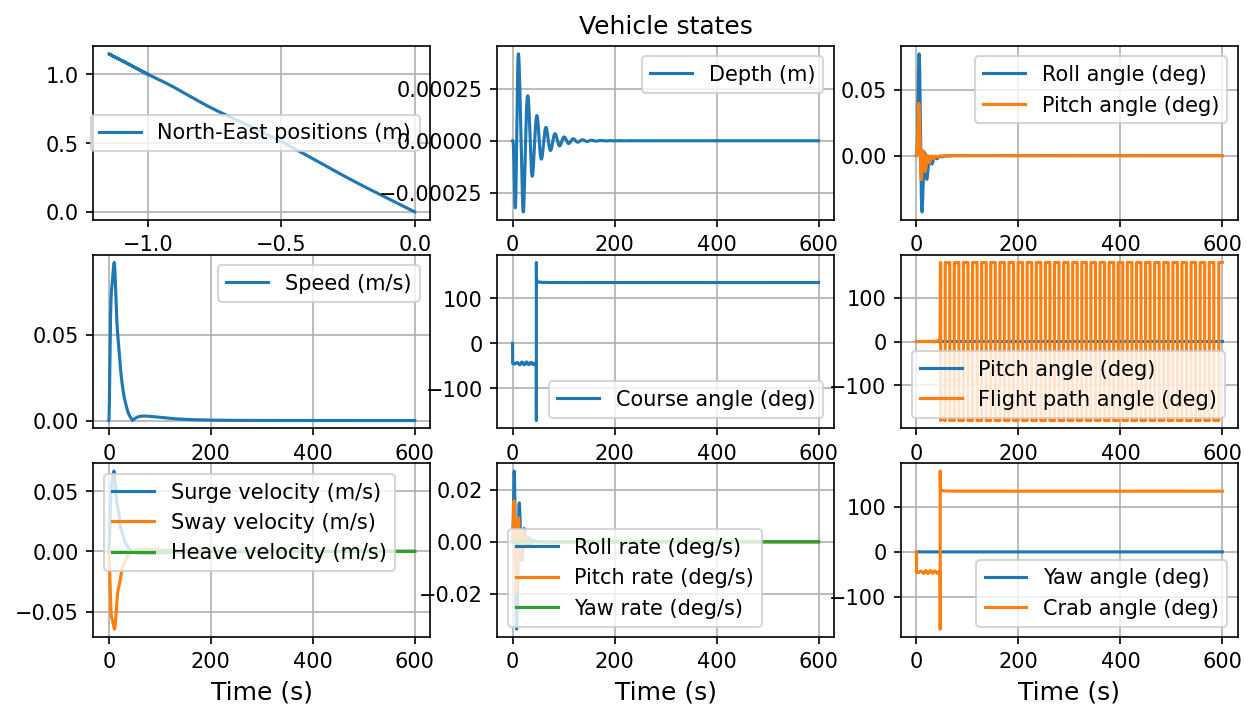

In [105]:
plotVehicleStates(simTime, simData, 3)

In [106]:
plot3D(simData, numDataPoints, FPS, filename, 3)

In [107]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [108]:
class MyTime:
    def __init__(self):
        self.my_t = 0
        self.v_m = np.array([0,0,0,0,0,0]).astype(np.float64)
        self.progression = [i for i in range(650)]
        self.wall_clock = datetime.now()
        self.x_ve = 0
        self.y_ve = 0
        self.z_ve = 0
        self.phi_ve = 0
        self.theta_ve = 0
        self.psi_ve = 0
        self.max_bending_strain = 0
        self.max_bending_strain1 = 0
        self.my_iter = 0

In [109]:
def inert(M, m, X):
    sum_=M
    ans=[]
    for i in range(len(X)-1,-1,-1):
        sum_+=m
        ans.append(np.array(sum_).copy())
    return np.array(ans)  

In [110]:
# V_rho=np.zeros(Jrho0.shape)
# np.fill_diagonal(V_rho, vessel_inertia)

In [111]:
# M_t=inert(vessel_mass*9.81,mp*9.81, x0)
# Jrho1=inert(V_rho, Jrho0, x0)

### Dynamics

In [112]:
def dynamic_func(t, Q, coefs, T, calibr):
    
    x,y,z=Q[0:N],Q[2*N:3*N],Q[4*N:5*N]
    dx,dy,dz=Q[1*N:2*N],Q[3*N:4*N],Q[5*N:6*N]
    φ,θ,ψ=Q[6*N:7*N],Q[8*N:9*N],Q[10*N:11*N]
    dφ,dθ,dψ=Q[7*N:8*N],Q[9*N:10*N],Q[11*N:12*N]
    
    idx = find_nearest(np.array(ans_t),  t)
    
    del_t = idx-T.my_t
    if del_t<0:
        idx=T.my_t
        
    x_ve = simData[:, 0][idx]
    y_ve = simData[:, 1][idx]
    z_ve = simData[:, 2][idx]
    phi_ve = ssa(simData[:, 3][idx])
    theta_ve = ssa(simData[:, 4][idx])
    psi_ve = ssa(simData[:, 5][idx])
    
    RET = Ret(φ,θ,ψ)

    vessel_movement = np.zeros(6)
    
    
    vessel_movement[0] = (x_ve - T.x_ve)
    vessel_movement[1] = (y_ve - T.y_ve)
    vessel_movement[2] = (z_ve - T.z_ve)
    vessel_movement[3] = (phi_ve - T.phi_ve)
    vessel_movement[4] = (theta_ve - T.theta_ve)
    vessel_movement[5] = (psi_ve - T.psi_ve)

    vessel_movement/=calibr
    

    fors, mom, angle = PipeForce(x, y, z, list(vessel_movement), coefs)
    
    Z0 = fors.squeeze()
    Z1 = d_s(ne, x, y, z, φ, θ, ψ).T
    Z2 = ne_hat(x, y, z, dx, dy, dz).T

    Z = (Z1 + Z2 - Z0)

############################################################
#     ddx,ddy, ddz = (Z/(M_t.reshape(-1, 1))).T
    ddx,ddy, ddz = (Z/Ws[0]).T    
############################################################
    
    C0 = np.einsum('ijk,ik->ij', Π(φ,θ,ψ), angle).squeeze()    
    C1 = d_s(me, φ, θ, ψ, φ, θ, ψ)
    C = (C1.T - C0)


    A0 = Jrho(RET,Jrho0)
#     A0 = Jrho(RET,Jrho1) 
    A_fin = np.einsum('ijk,ikr->ijr', A0, Π(φ,θ,ψ))
    

    B = np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ), np.stack((dφ,dθ,dψ), axis=1))
    
    D = w_e(φ,θ,ψ,dφ,dθ,dψ)
    
    G = np.cross(d_s(phi,x,y,z,φ, θ, ψ).T, ne(x, y, z, φ, θ, ψ))
    
    L = np.einsum('ijk,ik->ij',RET, (DR@D.T).T) 

    H = np.cross(D, np.einsum('ijk,ik->ij', A0, D))
    

#############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A_fin, (C + G - L - H - np.einsum('ijk,ik->ij', A0, B))).T
#############################################

    T.my_t=idx
    T.x_ve=x_ve
    T.y_ve=y_ve
    T.z_ve=z_ve
    T.phi_ve = phi_ve
    T.theta_ve = theta_ve
    T.psi_ve = psi_ve

    if t>T.progression[0]:
        T.progression.pop(0)
        print('Physical time: ', t, ' Iteration wall clock time: ', datetime.now() - T.wall_clock )
        T.wall_clock = datetime.now()   
         
    
    ans=np.concatenate([dx, ddx, 
                        dy, ddy, 
                        dz, ddz, 
                        dφ, ddφ, 
                        dθ, ddθ, 
                        dψ, ddψ
                       ], axis=0)
   
   
    ax=np.max(np.einsum('ijk,ik->ij',np.linalg.inv(RET),ne(x, y, z, φ, θ, ψ)))/(mp*9.81*h)
    W = 3.14*(d0**4-dI**4)/(32*d0)
    T.max_bending_strain=max(T.max_bending_strain,(ax*12/W)/E)
    
    ben=np.max(np.einsum('ijk,ik->ij',np.linalg.inv(RET), me(φ, θ, ψ, φ, θ, ψ)))/(mp*9.81*1**2)
    T.max_bending_strain1=max(T.max_bending_strain1,(ben/W)/E)
    
    T.my_iter+=1
    
    return ans

In [113]:
T_ = MyTime()

# initial conditions - to control dynamics
q0[6*N:7*N], q0[8*N:9*N], q0[10*N:11*N] = (np.array([0.01 for i in range(N)]),
                                          np.array([0.000001 for i in range(N)]),
                                          np.array([0.001257*i/N for i in range(N)]))

In [114]:
startTime1 = datetime.now()
us_ = solve_ivp(dynamic_func,
             tspan,
             q0,
             args=(coefs, T_, vessel_motion_calibration_coefficient,))
print(datetime.now() - startTime1)

Physical time:  2.1256512351911298e-07  Iteration wall clock time:  0:00:01.106819
Physical time:  1.0041417412840392  Iteration wall clock time:  0:01:11.866650
Physical time:  2.0428081055178797  Iteration wall clock time:  0:00:39.299359
Physical time:  3.0081623101041015  Iteration wall clock time:  0:00:42.299257
Physical time:  4.026565933152323  Iteration wall clock time:  0:00:40.283577
Physical time:  5.009219899797622  Iteration wall clock time:  0:00:45.825464
Physical time:  6.001115697189436  Iteration wall clock time:  0:00:49.170127
Physical time:  7.000620691192224  Iteration wall clock time:  0:00:47.536249
Physical time:  8.006383638891295  Iteration wall clock time:  0:00:42.013874
Physical time:  9.000288419230378  Iteration wall clock time:  0:00:37.224928
Physical time:  10.013376800284481  Iteration wall clock time:  0:00:36.493222
Physical time:  11.005889828699855  Iteration wall clock time:  0:00:44.557308
Physical time:  12.005576054035673  Iteration wall clo

In [115]:
# max bending strain
T_.max_bending_strain*mp*9.81*h

0.042786552035212394

In [116]:
T_.max_bending_strain1*mp*9.81*1**2

1.2305351335481756

In [117]:
# axial tension
W = 3.14*(d0**4-dI**4)/(32*d0)
T_.max_bending_strain*mp*9.81*h*W*E/12

2897562.3367289095

### Results

In [118]:
fin=us_

In [119]:
fin

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  2.126e-05 ...  4.990e+01  5.000e+01]
        y: [[ 0.000e+00  6.088e-25 ...  4.731e-04  4.749e-04]
            [ 1.347e+01  1.347e+01 ...  1.258e+01  1.258e+01]
            ...
            [ 0.000e+00 -1.420e-18 ... -1.523e-13 -1.600e-13]
            [ 0.000e+00 -8.574e-19 ... -6.325e-14 -5.989e-14]]
      sol: None
 t_events: None
 y_events: None
     nfev: 4112
     njev: 0
      nlu: 0

In [120]:
t=fin.t

In [121]:
fin=fin.y.T

In [122]:
t.shape, fin.shape

((568,), (568, 240))

In [123]:
fig=plt.figure(figsize=(13,13))
ax = fig.add_subplot(projection = '3d')

X0=fin[0,[i for i in range(0,N)]]
Y0=fin[0,[i for i in range(2*N,3*N)]]
Z0=fin[0,[i for i in range(4*N,5*N)]]

j=-1
X=fin[j,[i for i in range(0,N)]]
Y=fin[j,[i for i in range(2*N,3*N)]]
Z=fin[j,[i for i in range(4*N,5*N)]]

num_true_pts = 200
tck, u = interpolate.splprep([X,Y,Z], s=2)
u_fine = np.linspace(0,1,num_true_pts)
x_fine, y_fine, z_fine = interpolate.splev(u_fine, tck)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b')
# ax.plot(x_fine, y_fine, z_fine, color='b')
# ax.view_init(-45,-45)
# ax.view_init(-30,-30)
ax.view_init(0,-90)
plt.show()

In [124]:
X,Y,Z

(array([4.74945133e-04, 1.25776067e+01, 2.56327534e+01, 3.87858583e+01,
        5.19934493e+01, 6.52415794e+01, 7.85262783e+01, 9.18474523e+01,
        1.05200487e+02, 1.18571841e+02, 1.31949548e+02, 1.45328091e+02,
        1.58706747e+02, 1.72086552e+02, 1.85468503e+02, 1.98852786e+02,
        2.12240542e+02, 2.25631931e+02, 2.39027894e+02, 2.51308327e+02]),
 array([ 4.74911122e-08,  5.12380364e-04, -6.85301053e-04, -3.50152093e-03,
        -7.95750894e-03, -1.40707496e-02, -2.18521986e-02, -3.13105974e-02,
        -4.24518341e-02, -5.52789740e-02, -6.97888662e-02, -8.59806630e-02,
        -1.03852650e-01, -1.23407393e-01, -1.44639774e-01, -1.67560368e-01,
        -1.92156235e-01, -2.18441475e-01, -2.46408816e-01, -2.74834589e-01]),
 array([-2.80032657e-03,  7.62049397e-02,  3.19318866e-01,  7.28403005e-01,
         1.30419417e+00,  2.04727785e+00,  2.95826847e+00,  4.03785163e+00,
         5.28648248e+00,  6.70398933e+00,  8.28996617e+00,  1.00441501e+01,
         1.19664987e+01,  1.

In [125]:
X0,Y0,Z0

(array([  0.        ,  13.4657417 ,  26.93148341,  40.39722511,
         53.86296681,  67.32870851,  80.79445022,  94.26019192,
        107.72593362, 121.19167532, 134.65741703, 148.12315873,
        161.58890043, 175.05464213, 188.52038384, 201.98612554,
        215.45186724, 228.91760894, 242.38335065, 255.84909235]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),
 array([ 0.        ,  0.08691711,  0.34768291,  0.78234086,  1.39096341,
         2.17365196,  3.13053697,  4.26177789,  5.56756325,  7.04811064,
         8.70366682, 10.53450766, 12.54093829, 14.72329307, 17.08193569,
        19.61725922, 22.32968617, 25.21966855, 28.28768799, 31.53425578]))

In [126]:
us=fin.T

In [127]:
us.shape

(240, 568)

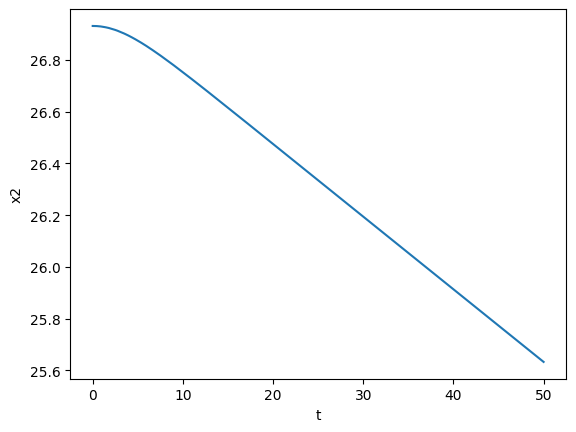

In [128]:
plt.plot(t,us.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

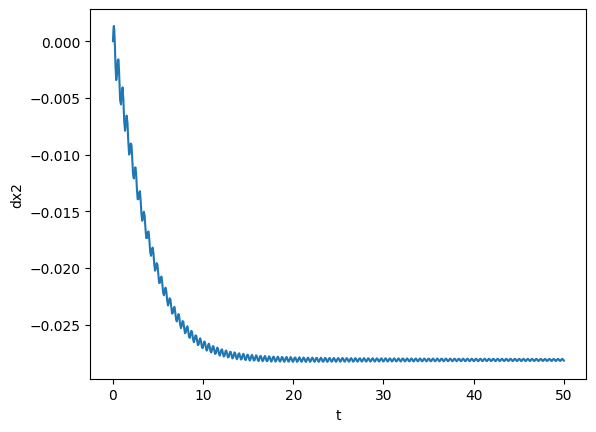

In [129]:
plt.plot(t,us.T[:,N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

In [130]:
plt.plot(t,us.T[:,N-1] ,'-')
plt.xlabel('t')
plt.ylabel('x{}'.format(N-1))
plt.show()

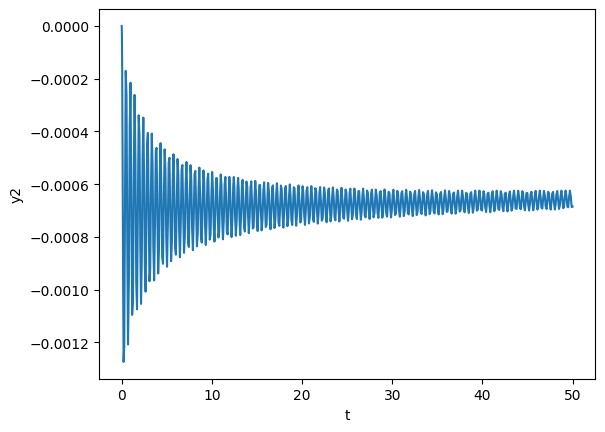

In [131]:
plt.plot(t,us.T[:,2*N +2] ,'-')
plt.xlabel('t')
plt.ylabel('y2')
plt.show()

In [132]:
plt.plot(t,us.T[:,3*N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dy2')
plt.show()

In [133]:
plt.plot(t,us.T[:,2*N+(N-1)] ,'-')
plt.xlabel('t')
plt.ylabel('y{}'.format(N-1))
plt.show()

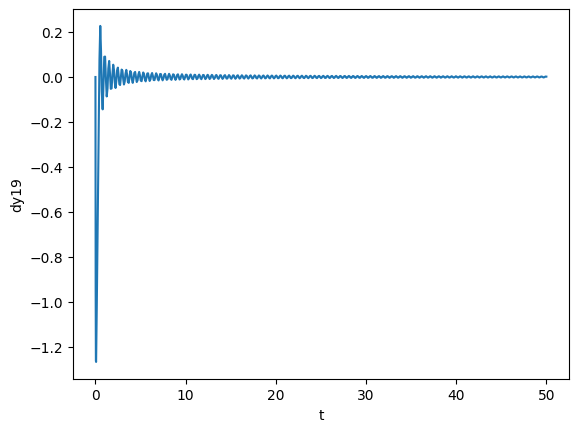

In [134]:
plt.plot(t,us.T[:,3*N+(N-1)] ,'-')
plt.xlabel('t')
plt.ylabel('dy{}'.format(N-1))
plt.show()

In [135]:
plt.plot(t,us.T[:,5*N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

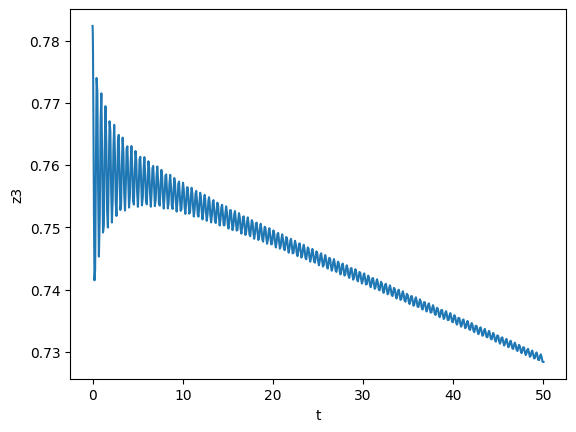

In [136]:
plt.plot(t,us.T[:,4*N+3] ,'-')
plt.xlabel('t')
plt.ylabel('z3')
plt.show()

In [137]:
plt.plot(t,us.T[:,4*N + (N-1)] ,'-')
plt.xlabel('t')
plt.ylabel('z{}'.format(N-1))
plt.show()

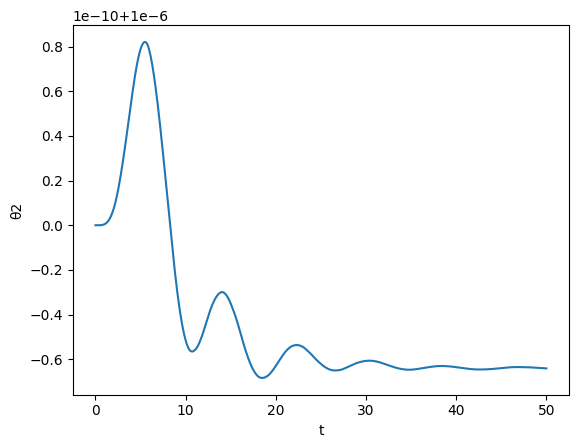

In [138]:
plt.plot(t,us.T[:,8*N+2],'-')
plt.xlabel('t')
plt.ylabel('θ2')
plt.show()

In [139]:
plt.plot(t,us.T[:,9*N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dθ2')
plt.show()

In [140]:
plt.plot(t,us.T[:,10*N+2],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

In [141]:
plt.plot(t,us.T[:,11*N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()

In [142]:
plt.plot(t,us.T[:,10*N + (N-1)] ,'-')
plt.xlabel('t')
plt.ylabel('ψ{}'.format(N-1))
plt.show()

In [143]:
X010=us.T[:,0*N:1*N]

In [144]:
Y010=us.T[:,2*N:3*N]

In [145]:
Z010=us.T[:,4*N:5*N]

In [146]:
simulation = np.stack([X010,Y010,Z010],axis=2) 

FPS = 30                      
frame_duration = 1000 / FPS

frames = []
for t in range(simulation.shape[0]):
    x = simulation[t,:,0]
    y = simulation[t,:,1]
    z = simulation[t,:,2]

    frames.append(go.Frame(
        data=[
            go.Scatter3d(
                x=x, y=y, z=z,
                mode="lines+markers",
                marker=dict(size=5, color=list(range(12)), colorscale="Viridis"),
                line=dict(width=4)
            )
        ],
        name=f"t={t}"
    ))

# First frame
x0, y0, z0 = simulation[0,:,0], simulation[0,:,1], simulation[0,:,2]

fig = go.Figure(
    data=[go.Scatter3d(x=x0, y=y0, z=z0, mode="lines+markers")],
    frames=frames
)

# Animation controls
fig.update_layout(
    title="Pipeline Simulation ",
    scene=dict(
        xaxis_title="X",
        yaxis_title="Y",
        zaxis_title="Z",
        xaxis=dict(range=[0, 300]),
        yaxis=dict(range=[-50, 50]),
        zaxis=dict(range=[0, 40]),
        aspectmode="data",
       
    ),
    updatemenus=[{
        "type": "buttons",
        "buttons": [
            {
                "label": "Play",
                "method": "animate",
                "args": [None, {"frame": {"duration": frame_duration, "redraw": True}}]
            },
            {
                "label": "Pause",
                "method": "animate",
                "args": [[None], {"frame": {"duration": 0}}]
            }
        ]
    }]
)

fig.show()